HD to Mel Encoding

In [1]:
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import re
from tqdm import trange
import copy
import tarfile
import soundfile as sf
import wget
import random
import pandas as pd

In [2]:
params = {}
params["target_steps"] = 800
params["num_bands"] = 80
params["num_classes"] = 20
params["sample_rate"] = 16000
params["pre_emphasis"] = 0.95
params["frame_length"] = 0.025
params["hop_length"] = 0.001
params["fft_size"] = 512
params["scale_value"] = 0.00099
params["save_directory_name"] = "rawHD_80input_updated"

In [3]:
### (1) download and allocate folders for google speech commands dataset ###

# get a directory to download and encode dataset files
directory = os.path.expanduser("~/data")

try:
    os.makedirs(directory)
except:
    pass
os.chdir(directory)

try:
    os.makedirs("rawHD")
except:
    pass
os.chdir("rawHD")

if not os.path.exists("hd_audio.tar.gz"):
    print("downloading dataset")
    wget.download("https://zenkelab.org/datasets/hd_audio.tar.gz")

# unzip to folder
if not os.path.isdir("hd_extracted"):
    # downloading the 35 classes version
    file = tarfile.open("hd_audio.tar.gz")

    file.extractall("./hd_extracted")

    file.close()

os.chdir("hd_extracted")
print("current cwd", os.getcwd())

current cwd /its/home/ts468/data/rawHD/hd_extracted


In [4]:
### (2) sort through dataset to get testing/training ###

# load a list of training audio files
train_files = []
with open("train_filenames.txt", "r") as file:
    for line in file:
        x = line[:-1]
        train_files.append(x)
        
# load a list of testing audio files
test_files = []
with open("test_filenames.txt", "r") as file:
    for line in file:
        x = line[:-1]
        test_files.append(x)

In [5]:
### (3) Mel Spectrogram encoding ###

def to_mel_spectrogram(file_name,
                       params, 
                       display = False):
    
    audio, sr = librosa.load(file_name, sr = params["sample_rate"], mono=True)
    
    # Apply pre-emphasis filter
    emphasized_audio = np.append(audio[0], 
                                 audio[1:] - params["pre_emphasis"] * audio[:-1])

    # Define frame length and stride in samples
    frame_length = int(sr * params["frame_length"])  # 25ms
    hop_length = int(sr * params["hop_length"])  # 10ms

    # Compute the power spectrum using a 512-point FF
    power_spectrum = np.abs(librosa.stft(emphasized_audio, 
                                         n_fft = params["fft_size"], 
                                         hop_length = hop_length, 
                                         win_length = frame_length))**2

    # Compute the filter banks with 40 triangular filters
    filter_banks = librosa.filters.mel(n_fft = params["fft_size"], 
                                       sr = sr, 
                                       n_mels = params["num_bands"])

    # Apply the filter banks to the power spectrum
    mel_spec = np.dot(filter_banks, power_spectrum)

    # Crop or pad to 80 steps by repeating the last frame
    current_steps = mel_spec.shape[1]
    if current_steps < params["target_steps"]:
        padding = np.zeros((params["num_bands"], params["target_steps"] - current_steps))
        mel_spec = np.hstack((mel_spec, padding))
    elif current_steps > params["target_steps"]:
        mel_spec = mel_spec[:, :params["target_steps"]]

    # Convert power spectrogram to dB scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    if display:
        # Display the filter banks with the 'viridis' colormap
        plt.figure(figsize=(8, 5))
        librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr, cmap='viridis')
        plt.colorbar(format='%+2.0f dB')
        #plt.title('Mel Filter Banks with Pre-Emphasis Filter (Cropped/Padded to 80 Steps)')
        plt.tight_layout()
        plt.show()
        
        print(mel_spec_db.shape)
    
    else:
        return mel_spec_db

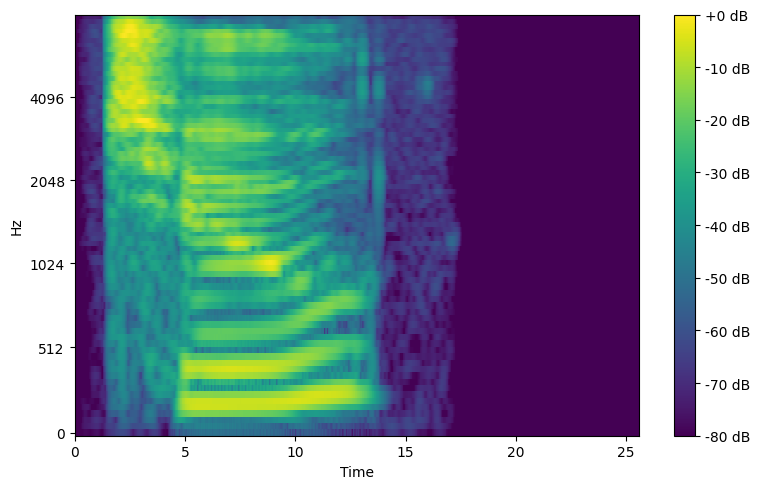

(80, 800)


/its/home/ts468/PhD/ve/genn_5_1_0/lib/python3.10/site-packages/matplotlib/axes/_axes.py:8264: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


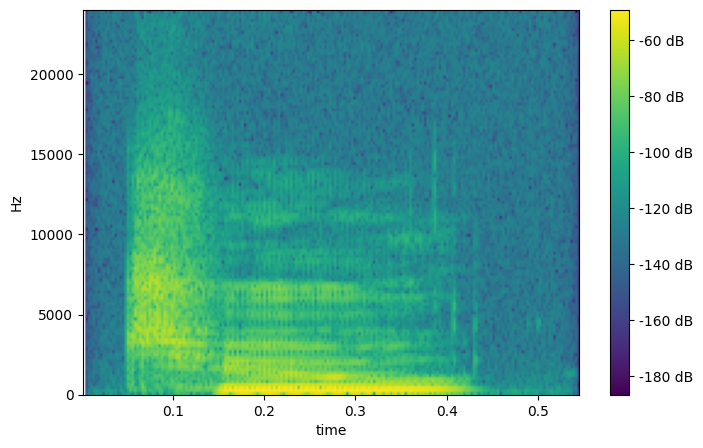

In [6]:
### (3.5) change directory and Visualise the output of the mel encoding

os.chdir("audio")

rnd_val = 10#np.random.randint(0, len(test_files))
test_image = train_files[rnd_val]
to_mel_spectrogram(test_image, params, True)

# Visualise the same input but on soecgram (visual check)
plt.figure(figsize=(8, 5))
data, samplerate = sf.read(test_image)  
Pxx, freqs, bins, im = plt.specgram(data, Fs=samplerate, cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.ylabel("Hz")
plt.xlabel("time")
plt.show()




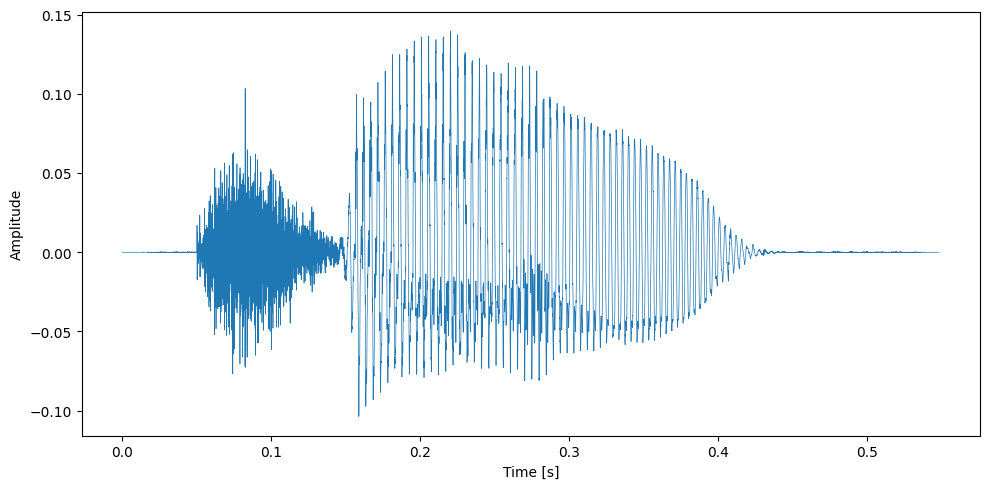

In [8]:
# Load the FLAC file
filename = test_image
data, samplerate = sf.read(filename)

# If stereo, convert to mono by averaging channels
if data.ndim > 1:
    data = data.mean(axis=1)

# Create time axis in seconds
time = np.linspace(0, len(data) / samplerate, num=len(data))

# Plot the waveform
plt.figure(figsize=(10, 5))
plt.plot(time, data, linewidth=0.5)
#plt.title('Waveform of FLAC Audio')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.tight_layout()
#plt.show()
plt.savefig("sign.pdf")

In [17]:
### (4) loop through audio and convert to Mel Encoding ###

training_x_data = []
training_y_data = []
testing_x_data = []
testing_y_data = []

training_details = pd.DataFrame({'Language': [], 
                                 'Speaker': [], 
                                 'Trial': [], 
                                 'Label': [],
                                 'classification label': []})

testing_details = pd.DataFrame({'Language': [], 
                                 'Speaker': [], 
                                 'Trial': [], 
                                 'Label': [],
                                 'classification label': []})

# save all to a list
for i in trange(len(os.listdir())):
    split_values = re.split("[. _ -]", os.listdir()[i])
    
    if os.listdir()[i] in train_files:
        training_x_data.append(copy.deepcopy(to_mel_spectrogram(os.listdir()[i], params)))
        training_y_data.append(int(split_values[7]) if split_values[1] == "english" else int(split_values[7]) + 10)
        training_details.loc[len(training_details)] = {'Language': split_values[1], 
                                                       'Speaker': int(split_values[3]), 
                                                       'Trial': int(split_values[5]), 
                                                       'Label': int(split_values[7]),
                                                       'classification label': (int(split_values[7]) if split_values[1] == "english" else int(split_values[7]) + 10)}
    else:
        testing_x_data.append(copy.deepcopy(to_mel_spectrogram(os.listdir()[i], params)))
        testing_y_data.append(int(split_values[7]) if split_values[1] == "english" else int(split_values[7]) + 10)
        testing_details.loc[len(testing_details)] = {'Language': split_values[1], 
                                                     'Speaker': int(split_values[3]), 
                                                     'Trial': int(split_values[5]), 
                                                     'Label': int(split_values[7]),
                                                     'classification label': (int(split_values[7]) if split_values[1] == "english" else int(split_values[7]) + 10)}

  2%|▏         | 242/10420 [00:04<03:08, 54.04it/s]


KeyboardInterrupt: 

In [8]:
### (5) Preprocess dataset with scaling and transposing

print(training_details.head())

# save dataset
os.chdir(directory)
# create new directory for raw HD
assert os.path.isdir("rawHD") == True
os.chdir("rawHD")

try:
    os.mkdir(params["save_directory_name"])
except:
    pass
  
os.chdir(params["save_directory_name"])
print("current cwd", os.getcwd())

print("pre processing data...")
# data processing
training_x_data = np.swapaxes(training_x_data, 1, 2) 
testing_x_data = np.swapaxes(testing_x_data, 1, 2) 

# move values into positive
training_x_data -= training_x_data.min()
testing_x_data -= testing_x_data.min()

# scale values 
training_x_data *= params["scale_value"]
testing_x_data = testing_x_data * params["scale_value"]

  Language  Speaker  Trial  Label  classification label
0   german        3      2      4                    14
1  english        2     37      5                     5
2   german        8     17      2                    12
3   german        1     15      6                    16
4  english        6     17      2                     2
current cwd /its/home/ts468/data/rawHD/rawHD_40input_updated
pre processing data...


In [ ]:
### (6) save dataset as npy ###

#np.save("training_x_data.npy", training_x_data)
#np.save("training_y_data.npy", training_y_data)
#np.save("testing_y_data.npy", testing_y_data)
#np.save("testing_x_data.npy", testing_x_data)

training_details.to_csv('training_details.csv')  
testing_details.to_csv('testing_details.csv')  

print("files saved:")
print(os.listdir())

files saved:
['training_x_data.npy', 'testing_details.csv', 'training_details.csv', 'testing_x_data.npy', 'training_y_data.npy', 'testing_y_data.npy']
